# Model power law data by sampling Fourier coefficients

We transform the Fourier coefficients so we can effectively sample from a standard normal distribution.

In [1]:
from jax import jit, vmap
import jax.numpy as jnp
import jax.random as jr
import jax.scipy as js
from jax.lax import cond
import numpyro
from numpyro.infer import NUTS, MCMC
from numpyro.distributions import Uniform, Normal, MultivariateNormal
import numpy as np
import matplotlib.pyplot as plt
from emcee.autocorr import integrated_time
from chainconsumer import Chain, ChainConsumer, Truth
import pandas as pd

In [2]:
# load PTMCMC sampler
import sys
import os

cwd = os.getcwd()
project_root = os.path.abspath(os.path.join(cwd, '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from samplers.ptmcmc import ptmcmc_sampler

## Simulate data

In [3]:
# time samples
Nt = 100
times = jnp.linspace(0., 1., Nt)
Tspan = times[-1] - times[0]

# frequency bins
Nf = 30
Na = 2 * Nf
freqs = jnp.arange(1, Nf + 1) / Tspan
F = jnp.zeros((Nt, Na))
for j in range(Nf):
    F = F.at[:, 2 * j].set(jnp.sin(2. * jnp.pi * freqs[j] * times))
    F = F.at[:, 2 * j + 1].set(jnp.cos(2. * jnp.pi * freqs[j] * times))

In [4]:
# covariance matrix for Fourier coefficients
def get_rho_diag(hyper_params):
    logamp, gamma = hyper_params
    amp = jnp.pow(10., logamp)
    return jnp.repeat(amp * jnp.pow(freqs, -gamma), 2)
fast_get_rho_diag = jit(get_rho_diag)

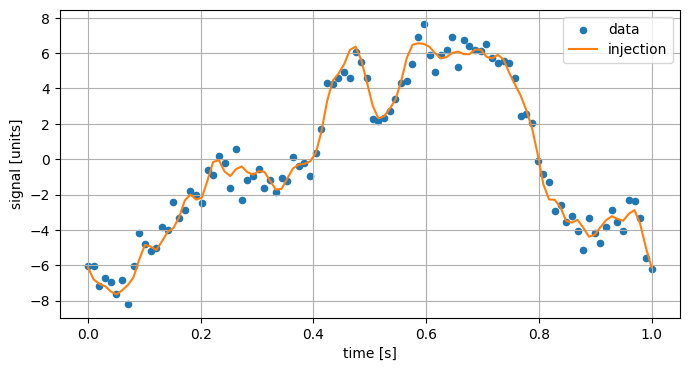

In [5]:
# injected parameters
logamp_inj = 1.2
gamma_inj = 2.7
hypers_inj = jnp.array([logamp_inj, gamma_inj])
sigma_inj = 0.7
rho_inj = fast_get_rho_diag(hypers_inj)
a_inj = jnp.sqrt(rho_inj) * jr.normal(jr.key(112), (Na,))
x_inj = jnp.concatenate((hypers_inj, jnp.array([sigma_inj]), a_inj))
ndim = x_inj.shape[0]

# simulate data
noise = jr.normal(jr.key(225), (Nt,)) * sigma_inj
signal_inj = F @ a_inj
data = signal_inj + noise
plt.figure(figsize=(8, 4))
plt.scatter(times, data, color='C0', label='data', s=20)
plt.plot(times, signal_inj, color='C1', label='injection')
plt.xlabel('time [s]')
plt.ylabel('signal [units]')
plt.legend()
plt.grid()
plt.show()

## Prior, likelihood, and posterior formulation

In [6]:
# parameter bounds
hyper_mins = jnp.array([-2., 1.])
hyper_maxs = jnp.array([5., 7.])
sigma_min = 0.1
sigma_max = 10.
a_min = -100.
a_max = 100.
x_mins = jnp.concatenate((hyper_mins, jnp.array([sigma_min]), jnp.array([a_min] * Na)))
x_maxs = jnp.concatenate((hyper_maxs, jnp.array([sigma_max]), jnp.array([a_max] * Na)))

# parameter labels
hyper_labels = np.array([r'$\log_{10}A$', r'$\gamma$'])
sigma_label = r'$\sigma$'
a_labels = np.array([rf'$a_{{{(i + 2) // 2}}}$' if i % 2 == 0 else rf'$b_{{{(i + 2) // 2}}}$'
                     for i in range(Na)])
x_labels = np.concatenate((hyper_labels, np.array([sigma_label]), a_labels))

In [7]:
# uniform prior
def uniform_lnprior(x):
    # check if parameters are in bounds
    out_of_bounds = jnp.logical_or(jnp.any(x < x_mins),
                                   jnp.any(x > x_maxs))
    def out_of_bounds_case():
        return -jnp.inf
    def in_bounds_case():
        return 0.0
    return cond(out_of_bounds, out_of_bounds_case, in_bounds_case)
fast_uniform_lnprior = jit(uniform_lnprior)

In [8]:
# get numerator term in prior
def get_aT_phiinv_a(a, lower_cholesky_phi):
    x = js.linalg.solve_triangular(lower_cholesky_phi, a, lower=True)
    return jnp.inner(x, x)
fast_get_aT_phiinv_a = jit(get_aT_phiinv_a)

# get normalization in prior
def get_lndet_phi(lower_cholesky_phi):
    return 2 * jnp.sum(jnp.log(jnp.diag(lower_cholesky_phi)))
fast_get_lndet_phi = jit(get_lndet_phi)

In [9]:
# prior on Fourier coefficients
def lnprior(x):
    # check if parameters are in bounds
    out_of_bounds = jnp.logical_or(jnp.any(x < x_mins),
                                   jnp.any(x > x_maxs))
    def out_of_bounds_case():
        return -jnp.inf
    def in_bounds_case():
        # unpack parameters
        hypers = x[:2]
        sigma = x[2]
        a = x[3:]
        # get covariance matrix
        phi_L = jnp.linalg.cholesky(jnp.diag(fast_get_rho_diag(hypers)), upper=False)
        return -0.5 * (fast_get_aT_phiinv_a(a, phi_L) + fast_get_lndet_phi(phi_L))
    return cond(out_of_bounds, out_of_bounds_case, in_bounds_case)
fast_lnprior = jit(lnprior)

In [10]:
# constants for likelihood
N = jnp.eye(Nt)
Ninv = jnp.linalg.inv(N)
U = data.T @ Ninv @ data
V = F.T @ Ninv @ data
W = F.T @ Ninv @ F
# likelihood
def lnlike(x):
    # unpack parameters
    hypers = x[:2]
    sigma = x[2]
    a = x[3:]
    return -0.5 * (U + a.T @ W @ a - 2 * jnp.inner(a, V)) / sigma**2. - Nt * jnp.log(sigma)
fast_lnlike = jit(lnlike)

In [11]:
# posterior
def lnpost(x):
    return fast_lnprior(x) + fast_lnlike(x)
fast_lnpost = jit(lnpost)
vectorized_lnpost = jit(vmap(fast_lnpost))

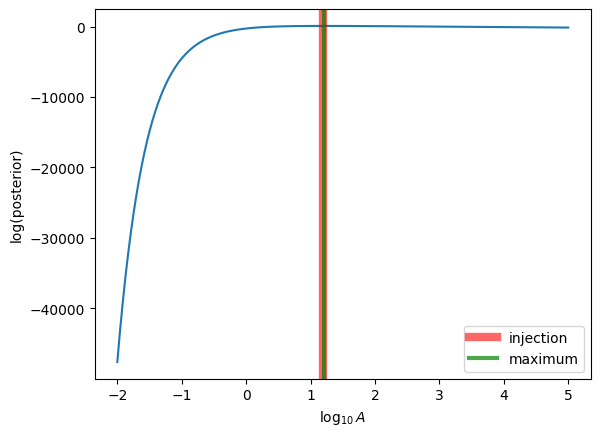

In [12]:
# plot cross-section of posterior
param_ndx = 0
num_evals = 1000
param_vals = jnp.linspace(x_mins[param_ndx], x_maxs[param_ndx], num_evals)
params = jnp.tile(x_inj, (num_evals, 1))
params = params.at[:, param_ndx].set(param_vals)
lnposts = vectorized_lnpost(params)
plt.plot(param_vals, lnposts)
plt.axvline(x_inj[param_ndx], color='red', label='injection', lw=6, alpha=0.6)
plt.axvline(param_vals[jnp.argmax(lnposts)], color='green', label='maximum', lw=3, alpha=0.7)
plt.legend()
plt.xlabel(x_labels[param_ndx])
plt.ylabel('log(posterior)')
plt.show()

## Sample with HMC

In [13]:
def sampling_model():
    hypers = numpyro.sample('hypers', Uniform(x_mins[:3], x_maxs[:3]))
    a = numpyro.sample('a', Normal(loc=jnp.zeros(Na), scale=jnp.sqrt(fast_get_rho_diag(hypers[:2]))))
    numpyro.factor('log-likelihood', fast_lnlike(jnp.concatenate([hypers, a])))

In [79]:
# do HMC with NUTS
num_HMC_samples = int(1e4)
num_warmup = 1000

nuts_kernel = NUTS(sampling_model)
mcmc = MCMC(nuts_kernel, num_warmup=num_warmup, num_samples=num_HMC_samples)
mcmc.run(jr.key(0))
samples_dict = mcmc.get_samples()
HMC_samples = np.concatenate((samples_dict['hypers'], samples_dict['a']), axis=1)

sample: 100%|██████████| 11000/11000 [00:04<00:00, 2328.46it/s, 31 steps of size 1.39e-01. acc. prob=0.95]


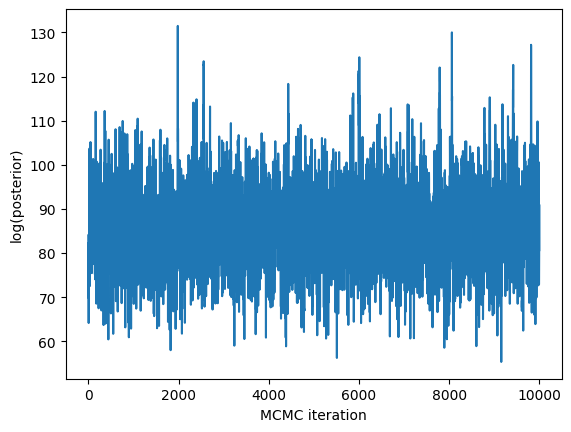

In [80]:
# plot posterior values
HMC_lnposts = vectorized_lnpost(HMC_samples)
plt.plot(HMC_lnposts)
plt.xlabel('MCMC iteration')
plt.ylabel('log(posterior)')
plt.show()

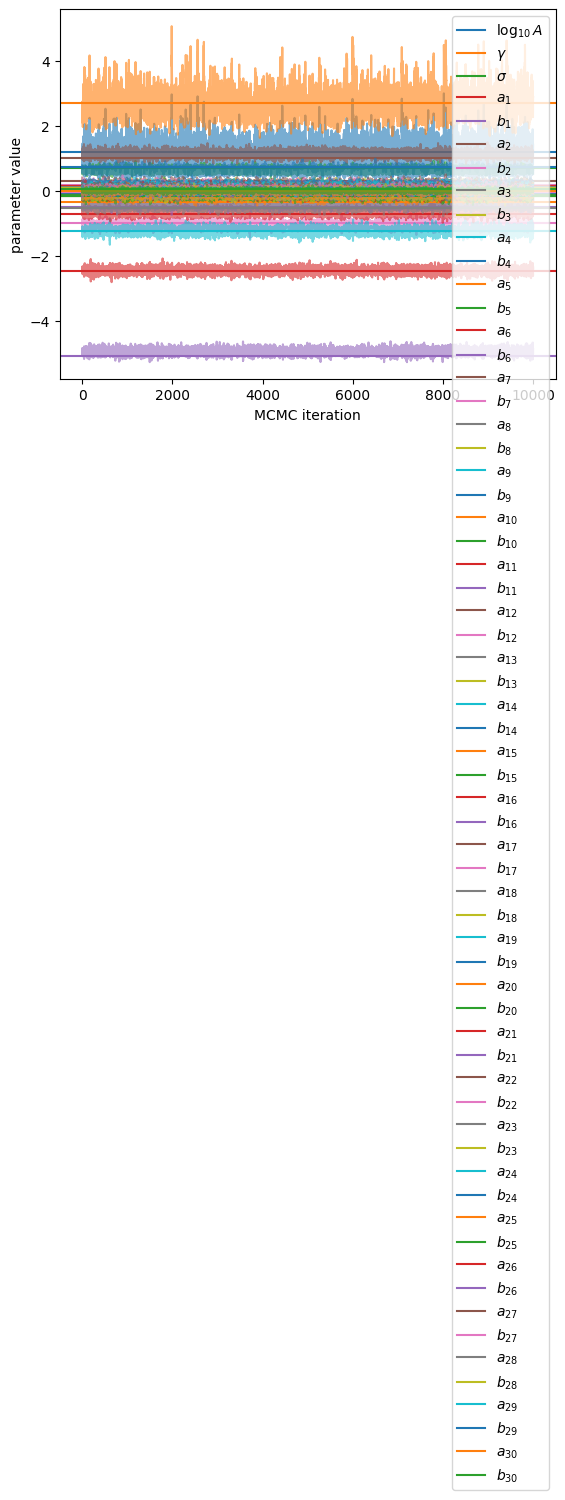

In [81]:
# trace plot
for i in range(ndim):
    plt.plot(HMC_samples[:, i], color=f'C{i}', alpha=0.6)
    plt.axhline(x_inj[i], color=f'C{i}', label=x_labels[i])
plt.xlabel('MCMC iteration')
plt.ylabel('parameter value')
plt.legend()
plt.show()

In [82]:
HMC_auto_correlation = int(np.round(integrated_time(HMC_samples[num_HMC_samples//10:])[0]))
HMC_Neff = HMC_samples.shape[0] // HMC_auto_correlation
print(f'auto-correlation length = {HMC_auto_correlation}')
print(f'effective sample size = {HMC_Neff}')
print(integrated_time(HMC_samples[num_HMC_samples//10:]))

auto-correlation length = 1
effective sample size = 10000
[0.9062208]


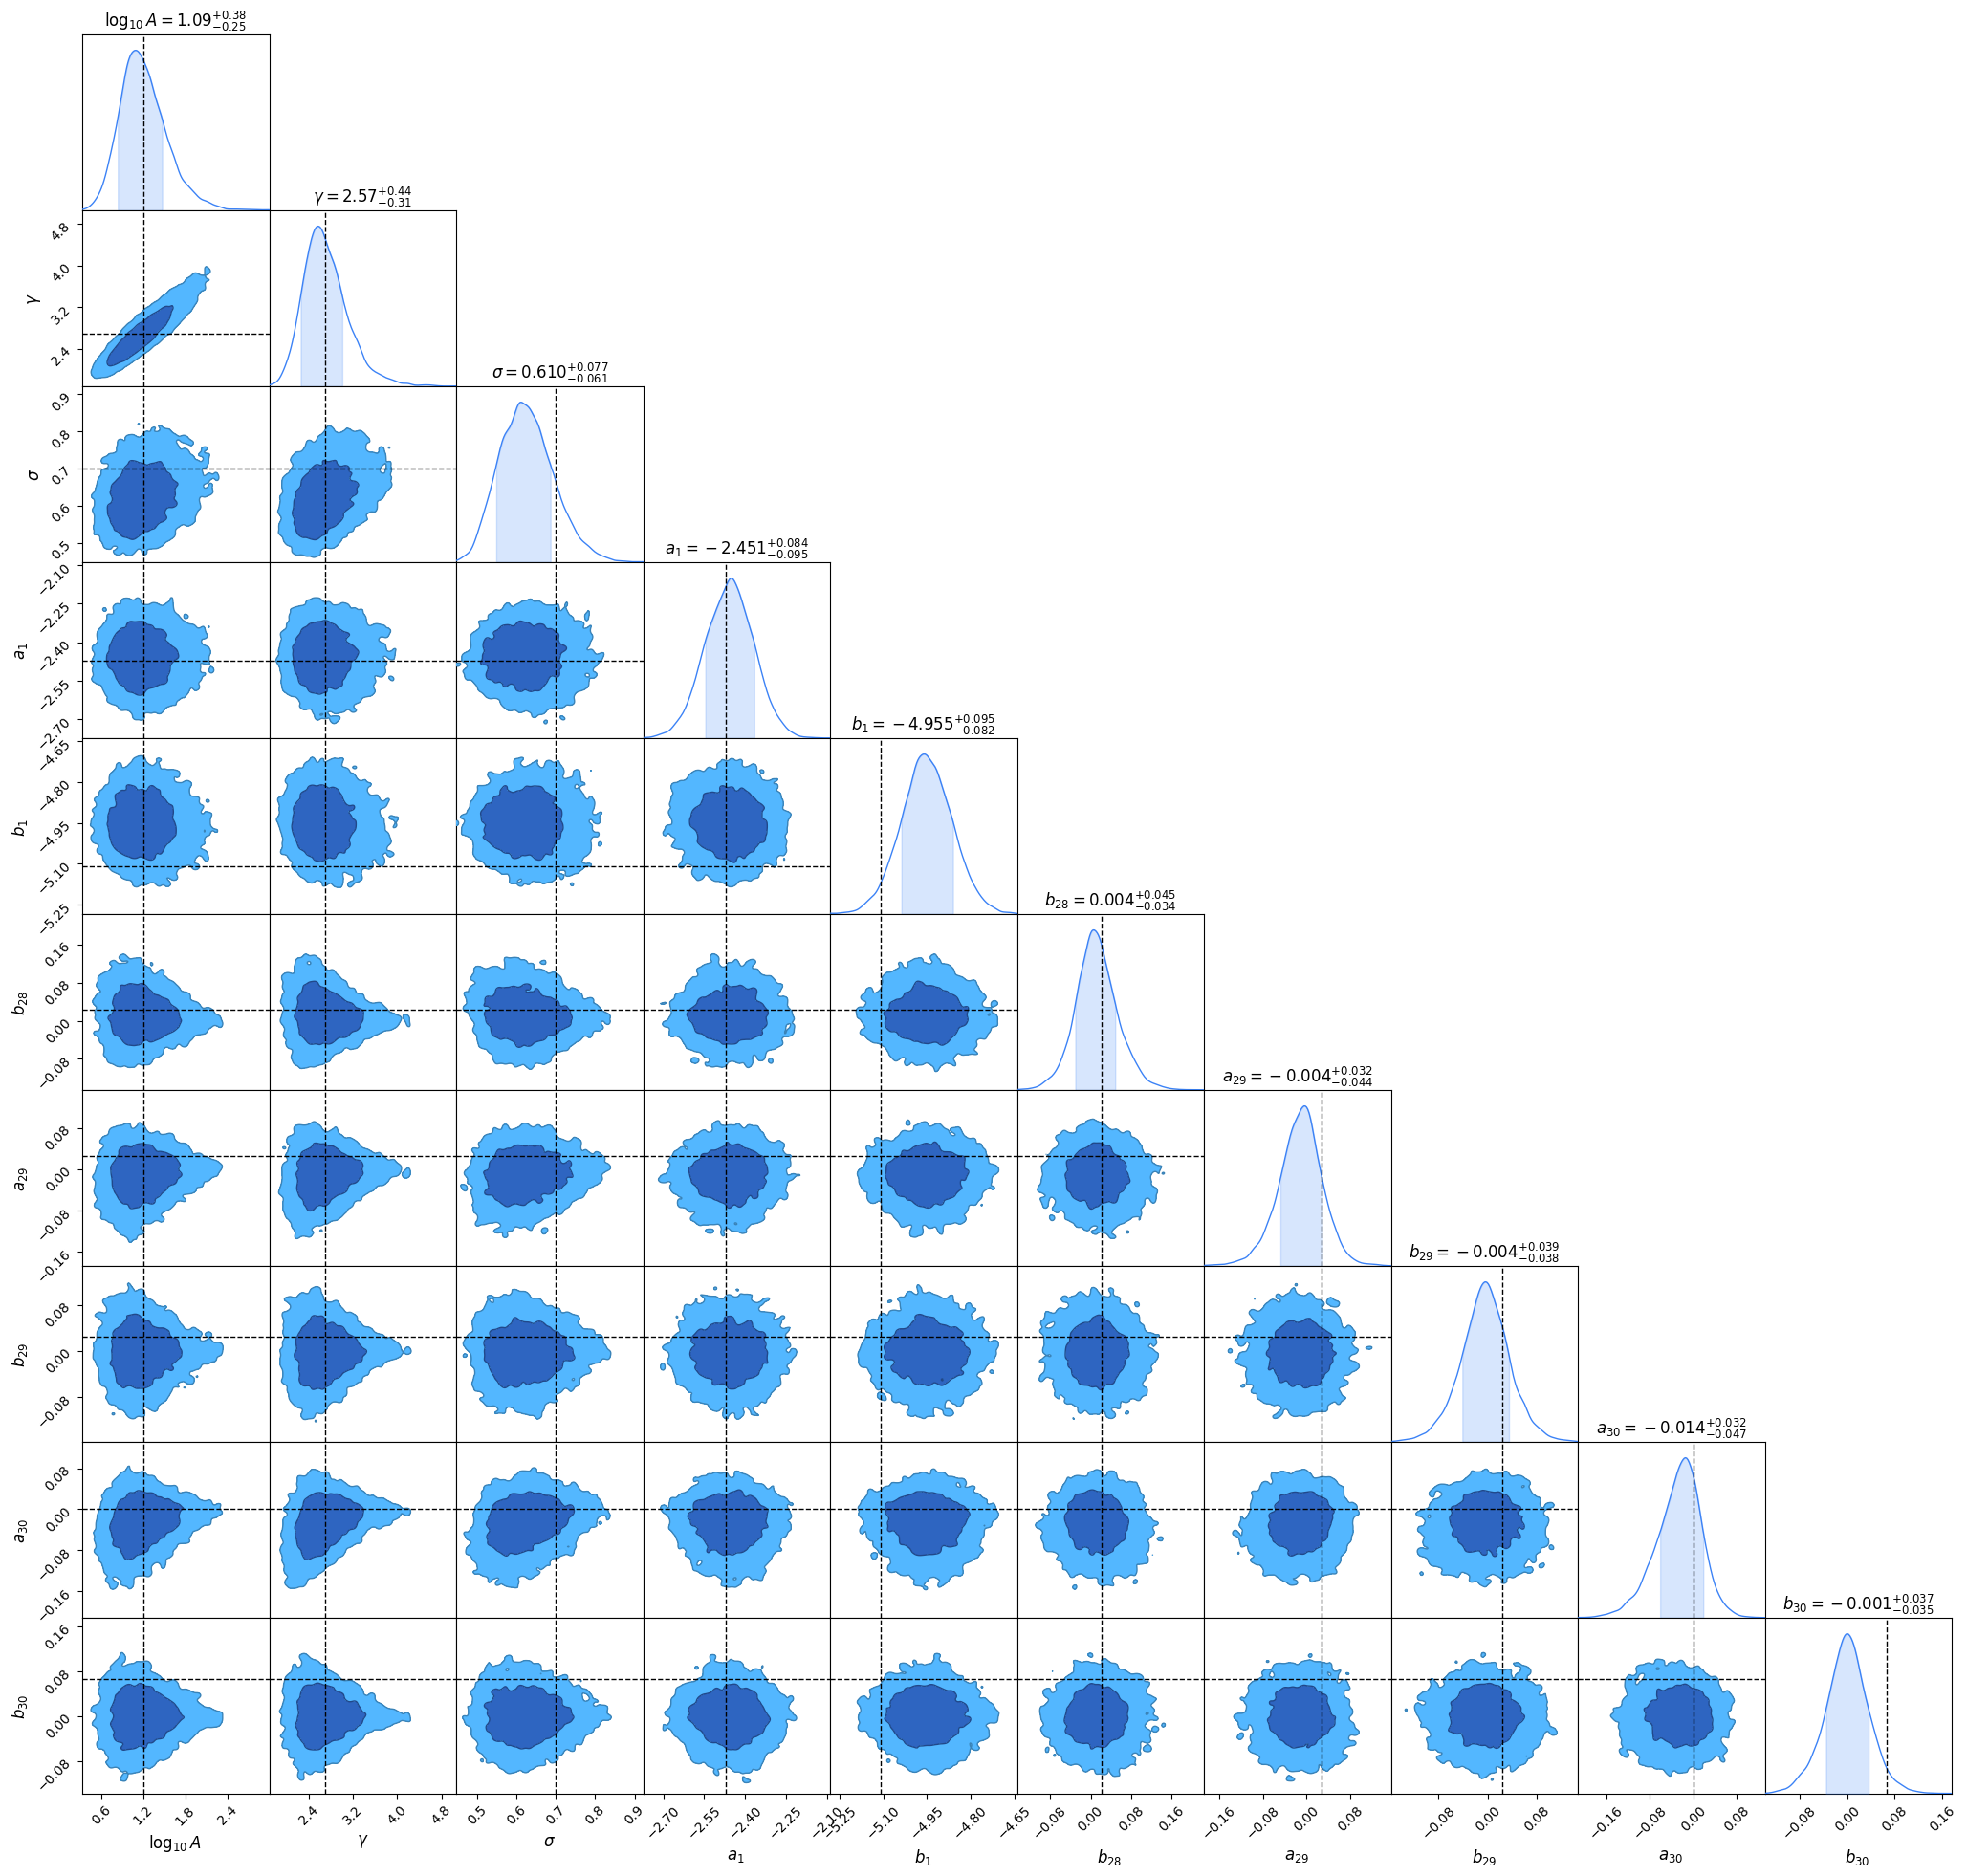

In [83]:
# corner plot
ndxs = np.concatenate((np.r_[:5], np.r_[-5:0]))
burnin = num_HMC_samples // 10
df_hmc = pd.DataFrame(HMC_samples[burnin::HMC_auto_correlation], columns=x_labels)
c = ChainConsumer()
c.add_chain(Chain(samples=df_hmc.iloc[:, ndxs], name='HMC'))
c.add_truth(Truth(location={name: val for name, val in zip(x_labels[ndxs], x_inj[ndxs])}))
fig = c.plotter.plot()

In [84]:
hypers_map = np.mean(HMC_samples[burnin::HMC_auto_correlation, :3], axis=0)
sigma_map = hypers_map[-1]
def get_a_mean_cov(hypers):
    # unpack parameters
    sigma = hypers[-1]
    Sigma_inv = W / sigma**2. + jnp.diag(1. / fast_get_rho_diag(hypers[:-1]))
    L_Sigma_inv = jnp.linalg.cholesky(Sigma_inv, upper=True)
    a_map = js.linalg.solve_triangular(L_Sigma_inv.T, js.linalg.solve_triangular(L_Sigma_inv, V / sigma**2., lower=False), lower=True)
    L_Sigma = js.linalg.solve_triangular(L_Sigma_inv, jnp.eye(Na)).T
    Sigma = L_Sigma @ L_Sigma.T
    return a_map, Sigma, L_Sigma
fast_get_a_mean_cov = jit(get_a_mean_cov)
vectorized_get_a_mean_cov = jit(vmap(fast_get_a_mean_cov))

# sample coefficients
def sample_a(mean, cov, key):
    return jr.multivariate_normal(key, mean, cov)
vectorize_sample_a = jit(vmap(sample_a, in_axes=(0, 0, 0)))

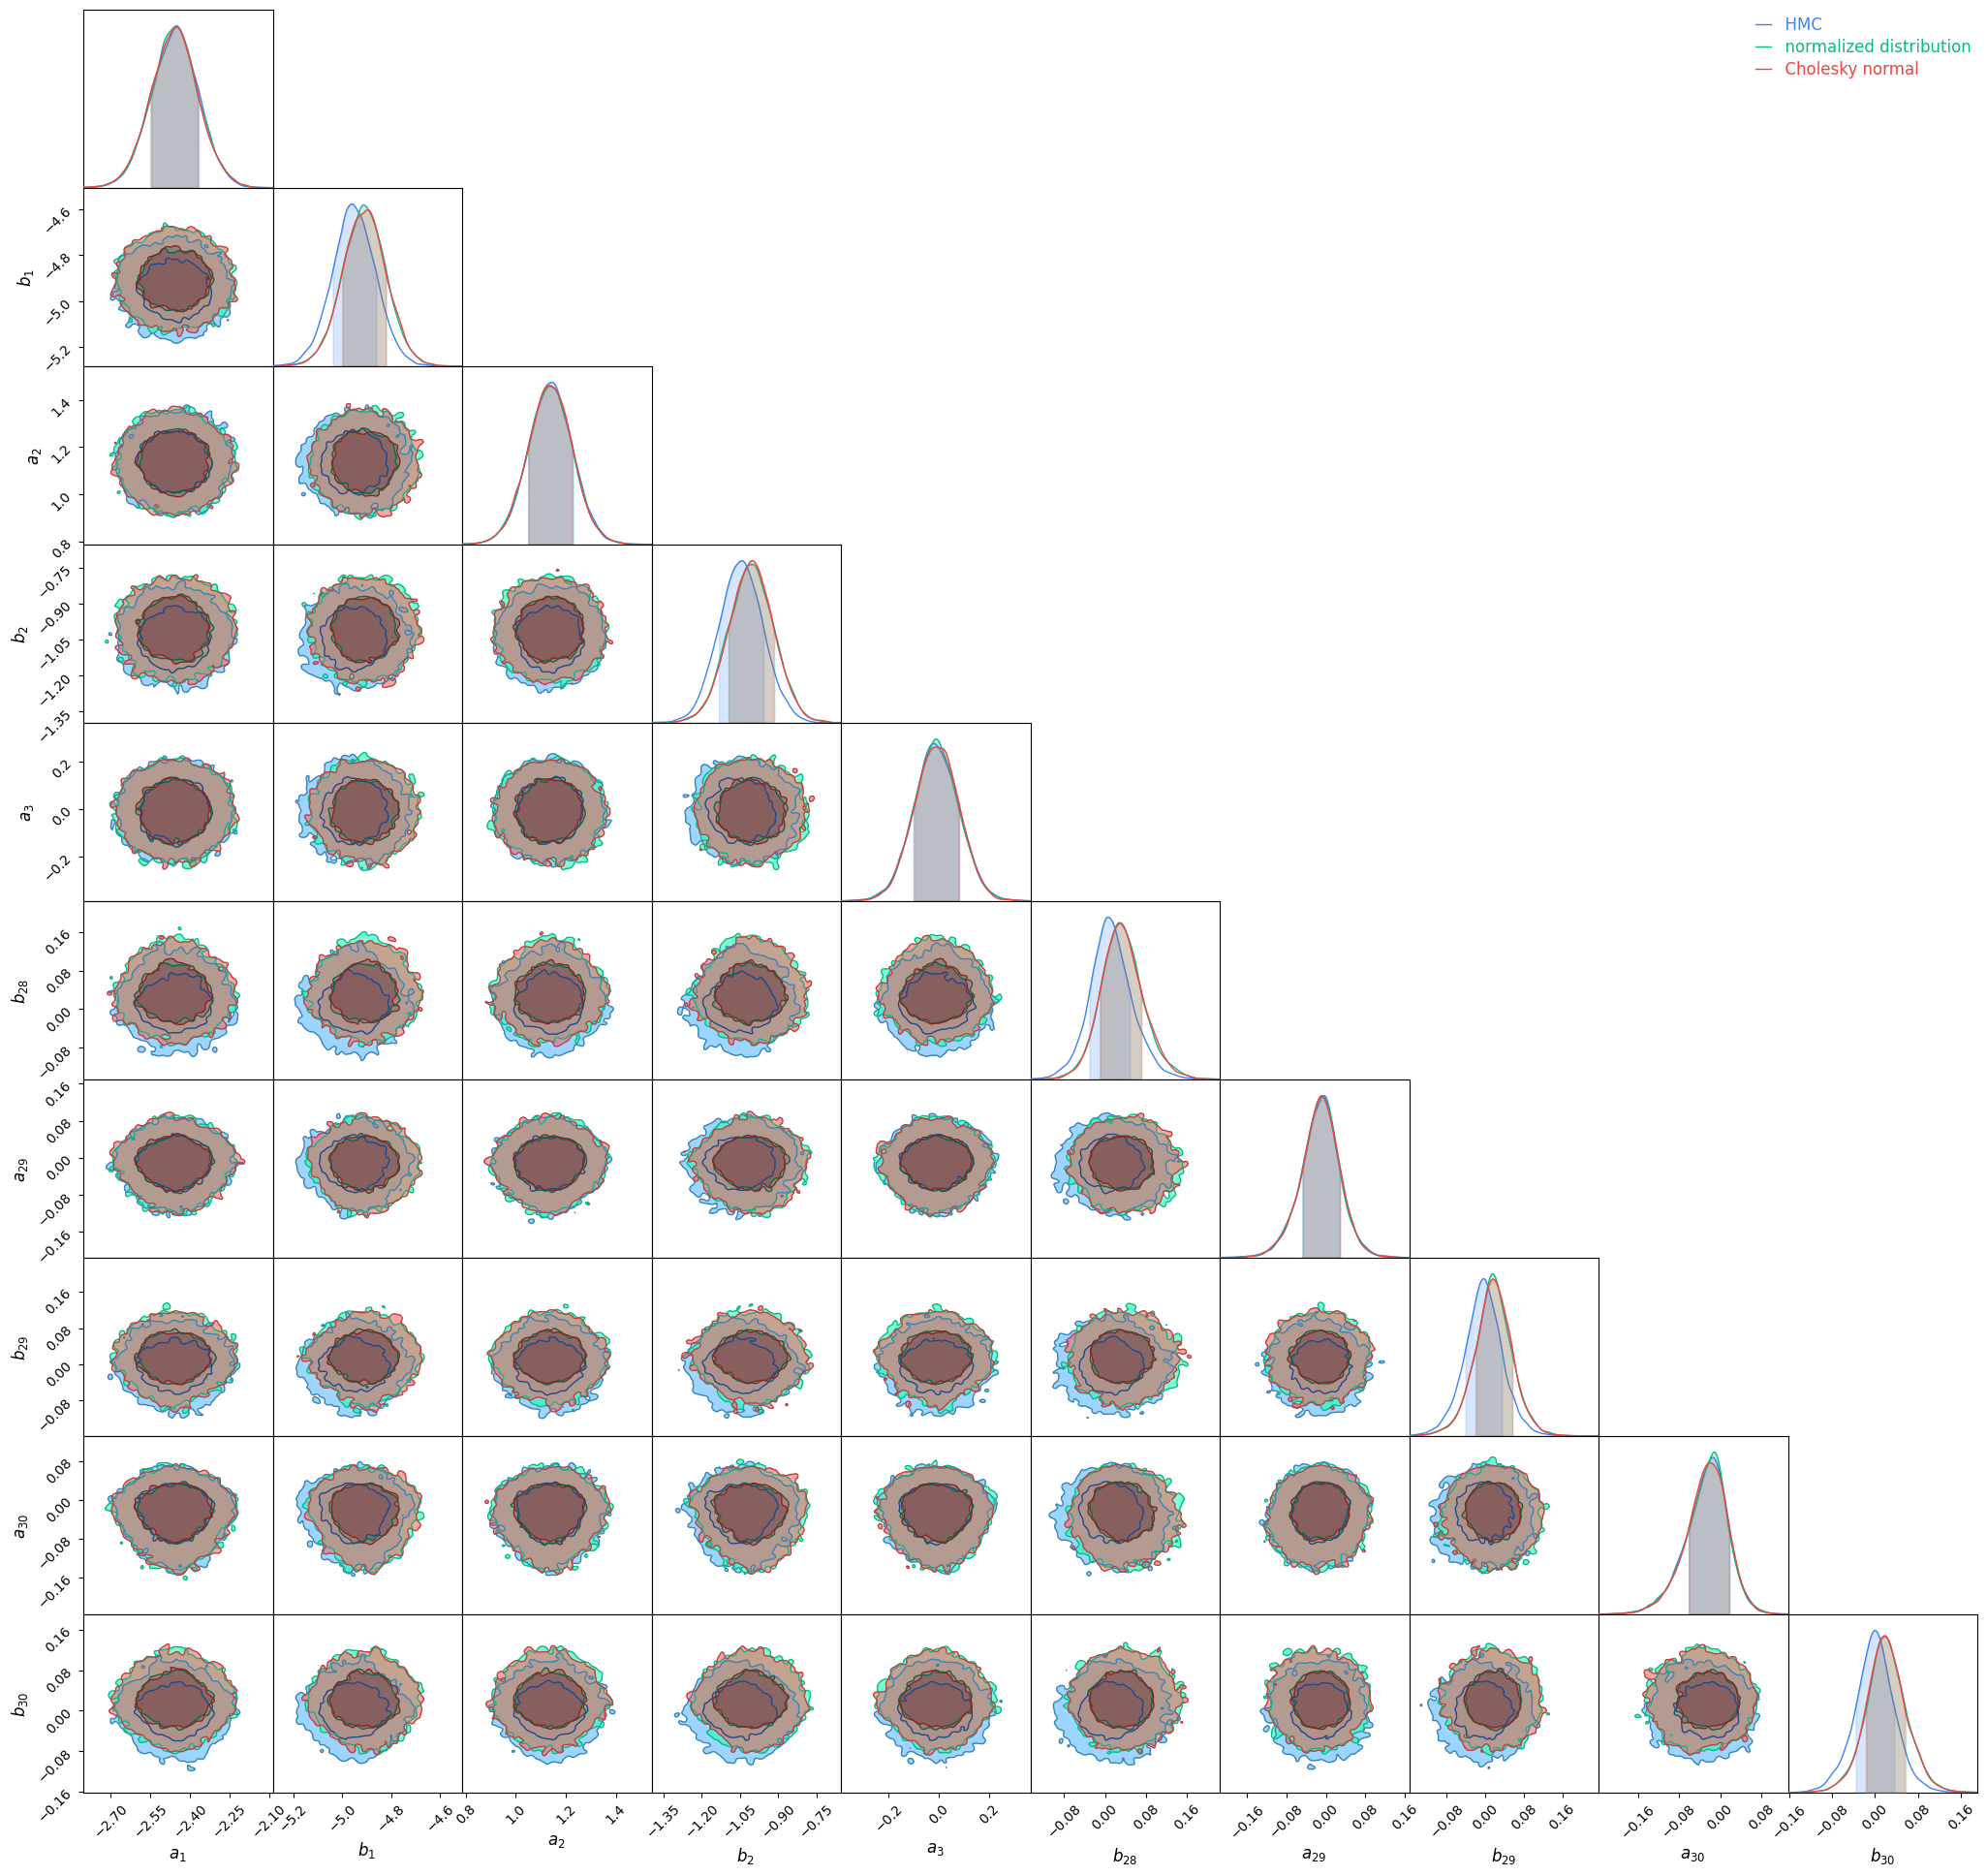

In [85]:
# multivariate normal distribution on Fourier coefficients
hyper_samples = HMC_samples[:, :3]
means, covs, L_sigmas = vectorized_get_a_mean_cov(hyper_samples)
a_samples = vectorize_sample_a(means, covs, jr.split(jr.key(0), num_HMC_samples))
a_samples1 = np.array([mean + L_sigma @ norm for mean, L_sigma, norm in zip(means, L_sigmas, np.random.normal(loc=0, scale=1., size=(num_HMC_samples, Na)))])
df_a_normal = pd.DataFrame(a_samples, columns=a_labels)
df_a_normal1 = pd.DataFrame(a_samples1, columns=a_labels)
a_ndxs = np.concatenate((np.r_[:5], np.r_[55:60]))
c = ChainConsumer()
c.add_chain(Chain(samples=df_hmc.iloc[:, 3 + a_ndxs], name='HMC'))
c.add_chain(Chain(samples=df_a_normal.iloc[:, a_ndxs], name='normalized distribution'))
c.add_chain(Chain(samples=df_a_normal1.iloc[:, a_ndxs], name='Cholesky normal'))
fig = c.plotter.plot()

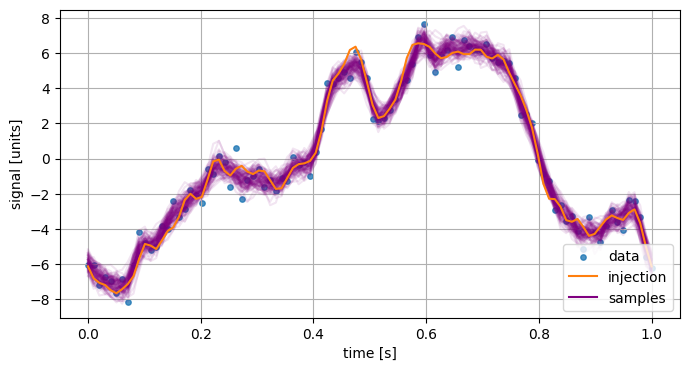

In [86]:
# Bayesogram
num_draws = 100
plt.figure(figsize=(8, 4))
plt.scatter(times, data, color='C0', s=15, alpha=0.8, label='data')
_ = [plt.plot(times, F @ samp[3:], color='purple', alpha=10./num_draws)
     for samp in jr.choice(jr.key(0), HMC_samples, (num_draws,))]
plt.plot(times, signal_inj, color='C1', label='injection')
plt.plot([], [], color='purple', label='samples')
plt.xlabel('time [s]')
plt.ylabel('signal [units]')
plt.legend(loc='lower right')
plt.grid()
plt.show()

## Sample standardized posterior

In [87]:
def lnpost_standard(x_standard):
    a_map, Sigma, L = fast_get_a_mean_cov(x_standard[:3])
    a = a_map + L @ x_standard[3:]
    log_det_jacobian = jnp.sum(jnp.log(jnp.diag(L)))
    return fast_lnpost(x_standard.at[3:].set(a)) + 0.5 * jnp.sum(x_standard[3:]**2.) + log_det_jacobian, a
fast_lnpost_standard = jit(lnpost_standard)

In [88]:
def standard_sampling_model():
    # Sample hyperparameters (includes hypers[2] = sigma)
    hypers = numpyro.sample('hypers', Uniform(jnp.array(x_mins[:3]), jnp.array(x_maxs[:3])))

    # Sample standard normal coefficients
    z = numpyro.sample('a_standard', Normal(0., 1.).expand([Na]))

    # get posterior and coefficients
    lnpost_val, a = fast_lnpost_standard(jnp.concatenate((hypers, z)))
    numpyro.deterministic('a', a)

    # Correct log posterior (reparam trick)
    numpyro.factor('log-posterior', lnpost_val)



a_standard_labels = np.array([rf'$c_{{{(i + 2) // 2}}}$' if i % 2 == 0 else rf'$d_{{{(i + 2) // 2}}}$'
                     for i in range(Na)])
z_labels = np.copy(x_labels)
z_labels[3:] = a_standard_labels
z_inj = jnp.copy(x_inj).at[3:].set(jnp.zeros(Na))

In [89]:
# do HMC
standard_nuts_kernel = NUTS(standard_sampling_model)
num_HMC_samples = int(1e4)
num_warmup = 1000
mcmc = MCMC(standard_nuts_kernel, num_warmup=num_warmup, num_samples=num_HMC_samples)
mcmc.run(jr.key(2))
standard_samples_dict = mcmc.get_samples()
standard_samples = jnp.concatenate((standard_samples_dict['hypers'], standard_samples_dict['a_standard']), axis=1)
unstandard_samples = jnp.concatenate((standard_samples_dict['hypers'], standard_samples_dict['a']), axis=1)

sample: 100%|██████████| 11000/11000 [00:21<00:00, 510.38it/s, 15 steps of size 2.40e-01. acc. prob=0.92]


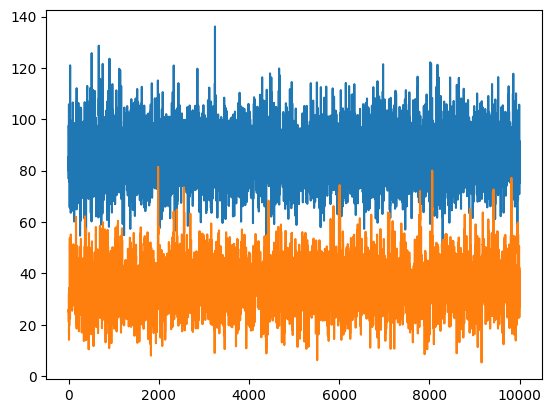

In [90]:
plt.plot(vectorized_lnpost(unstandard_samples))
plt.plot(HMC_lnposts - 50)

In [92]:
print(integrated_time(vectorized_lnpost(unstandard_samples)))
print(integrated_time(HMC_lnposts))
print(integrated_time(unstandard_samples))
print(integrated_time(HMC_samples))

[1.55085289]
[6.75285159]
[0.71584193]
[0.90787344]


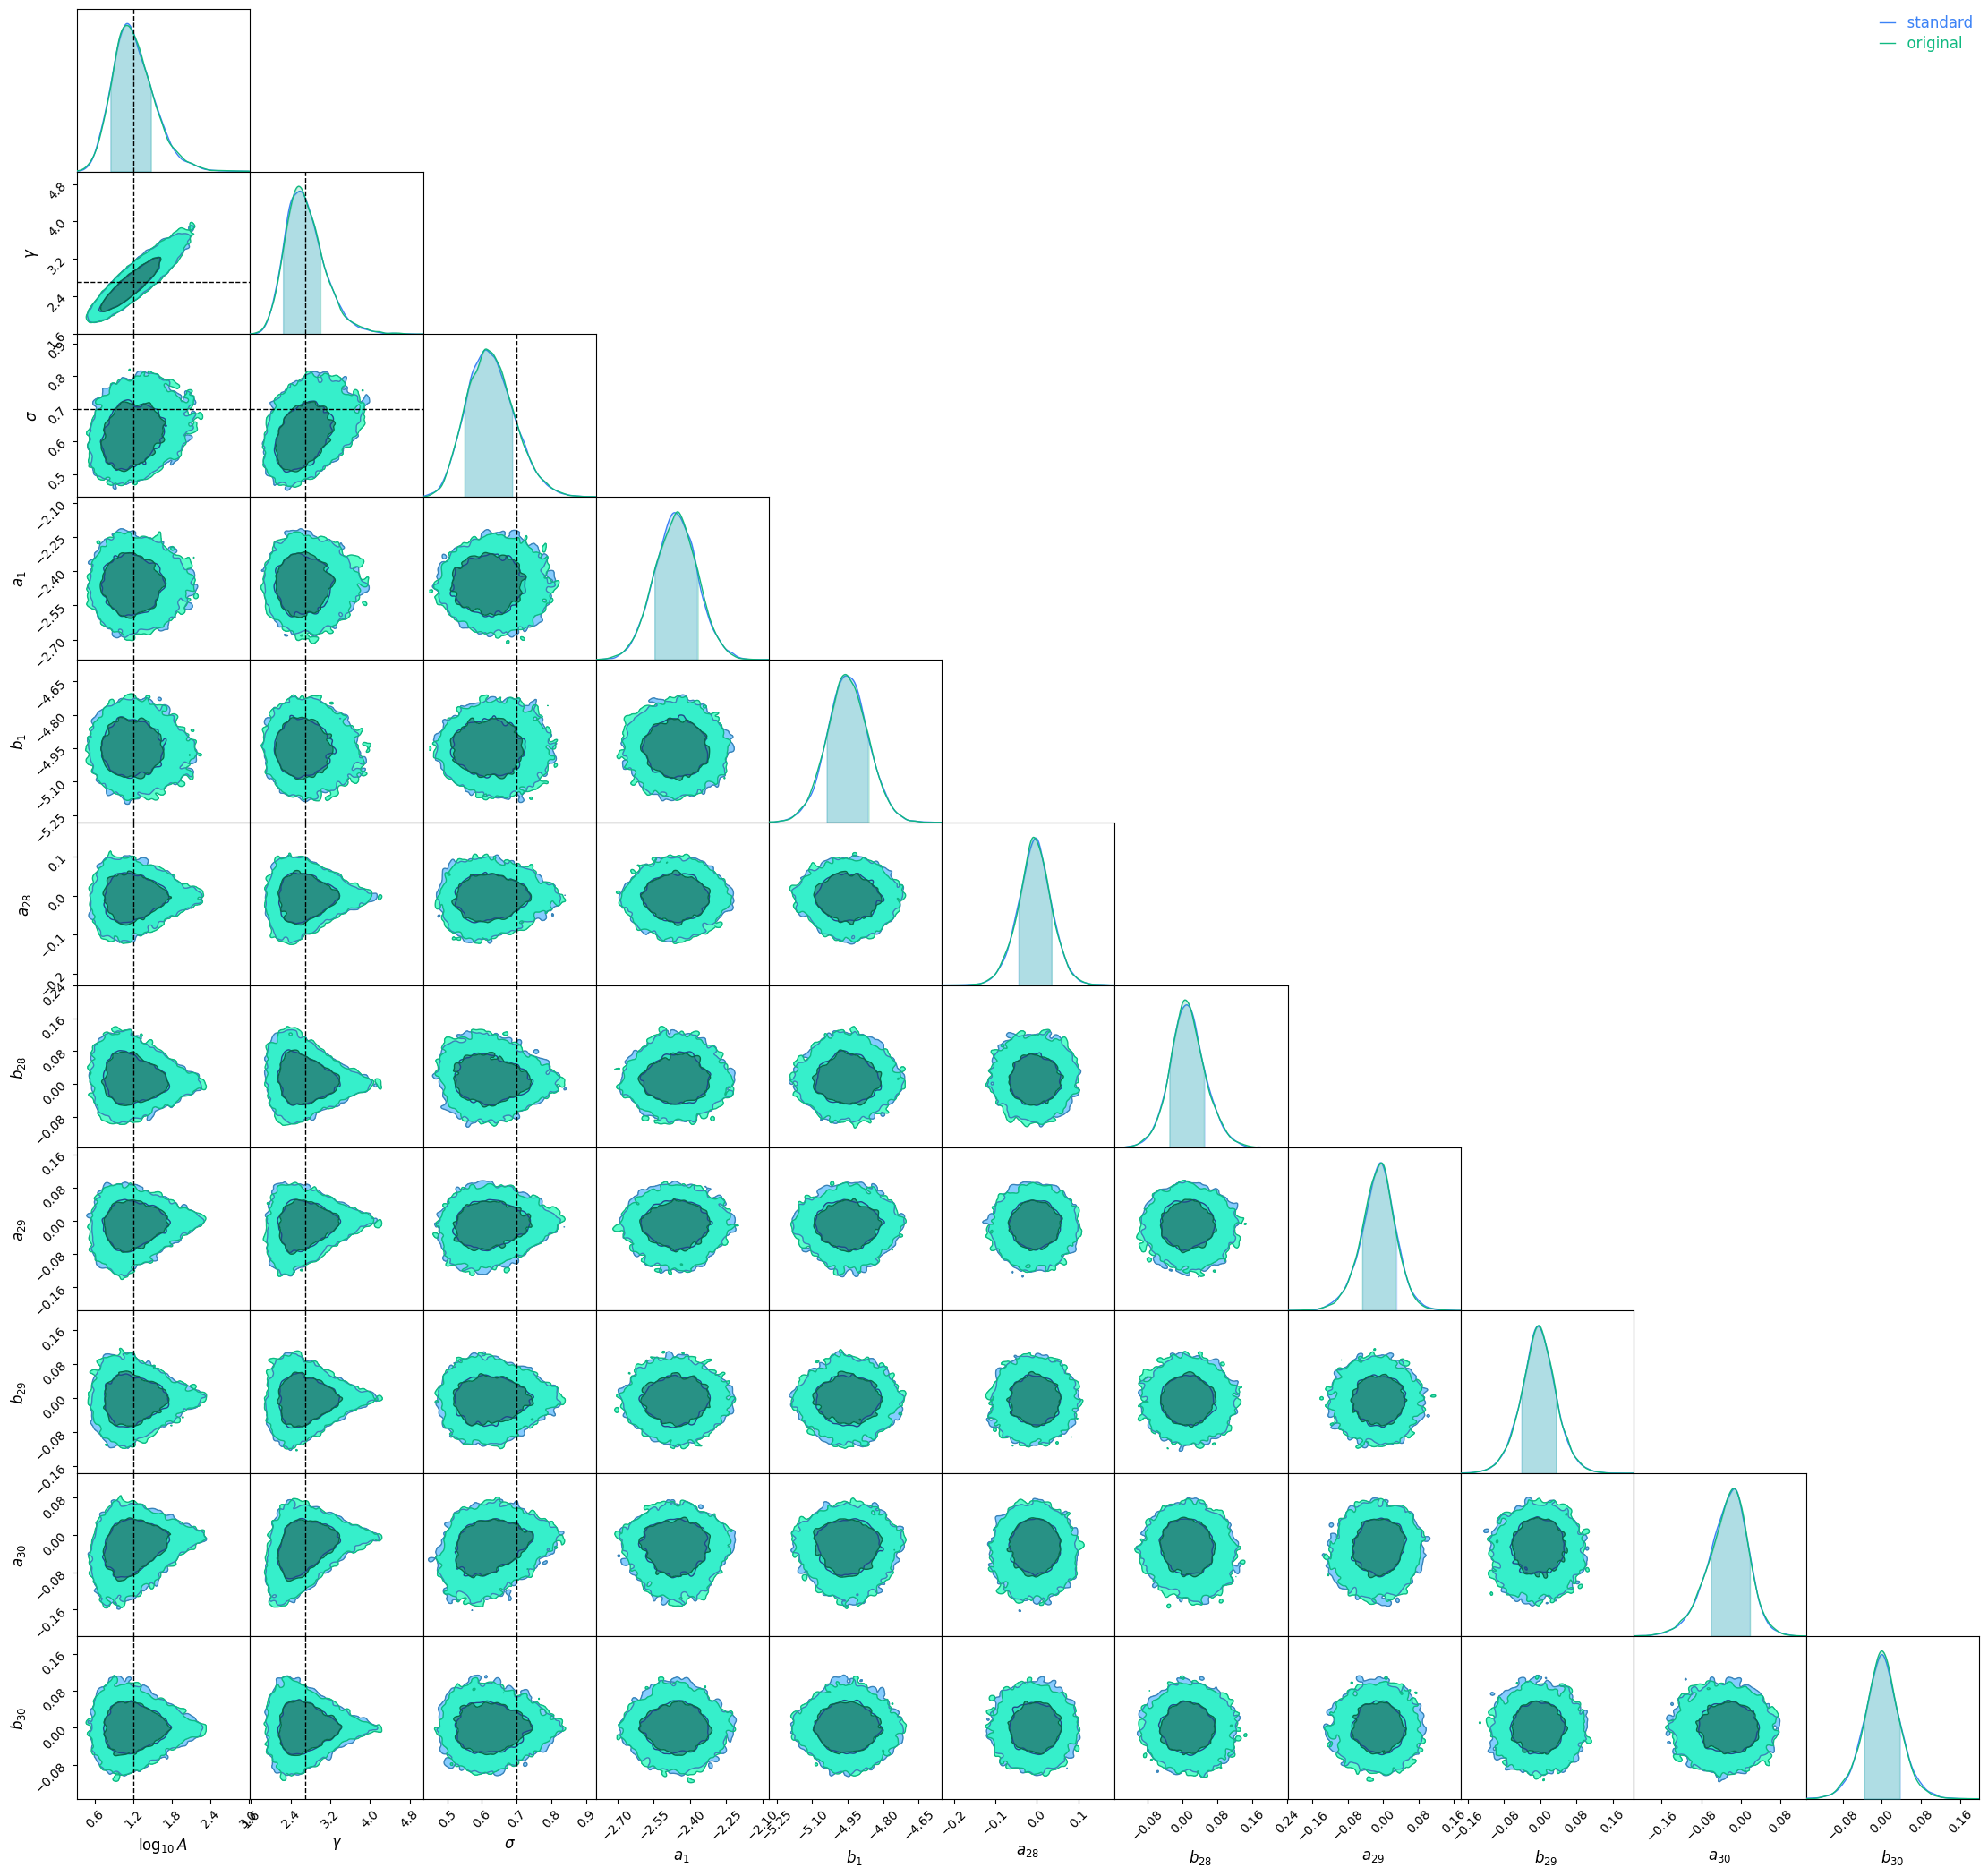

In [94]:
# plot standardized posterior
st_ndxs = np.concatenate((np.r_[:5], np.r_[-6:0]))
df_standard = pd.DataFrame(unstandard_samples, columns=x_labels)
c = ChainConsumer()
c.add_chain(Chain(samples=df_standard.iloc[:, st_ndxs], name='standard'))
c.add_chain(Chain(samples=df_hmc.iloc[:, st_ndxs], name='original'))
c.add_truth(Truth(location={name: val for name, val in zip(z_labels, z_inj)}))
fig = c.plotter.plot()